# Notebook lecture 8: Stability and Performance Robustness
&copy; 2025 ETH Zurich, Joël Gmür, Joël Lauper, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Joël Gmür; jgmuer@ethz.ch
- Joël Lauper; jlauper@ethz.ch

## Description
This week's Jupyter notebook will include the small-gain theorem, the stability of feedback control schemes, and performance robustness. 

To start, run the following cell to install the necessary modules and import the libraries.

In [ ]:
!pip install numpy scipy matplotlib ipywidgets control

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
import control as ctrl
from IPython.display import display, clear_output

np.set_printoptions(suppress=True, precision=3)

# Exercise 1: Small-gain theorem
## Check the Small Gain Theorem condition
This function checks if the loop gain $|\alpha P_1(s) * P_2(s)| < 1$ for all frequencies. Remember: We can only use the small gain theorem if $P_1$ and $P_2$ are stable. We use here a SISO system which is easier regarding stability and pole calculation.

Parameters:
    - Amplification $\alpha = 1$
    - Transfer function of the system $P_1(s)$
    - Transfer function of the feedback $P_2(s)$
    
    Returns:
    - True if the Small Gain Theorem holds, i.e., system is stable
    - False if the Small Gain Theorem does not hold, i.e., system is unstable

<img src=./images/block_diagram_0.png alt="Image" width="600" height="200"> 

In [54]:
def check_stability(P):
    # Get the poles of the transfer function
    poles = ctrl.poles(P)  # Correct method is `ctrl.poles(P)`
    
    # Check if any pole has a positive real part (right half-plane)
    for pole in poles:
        if pole.real > 0:
            return False  # System is unstable
    return True  # System is stable

def small_gain_theorem(P1, P2):
    # Check if P1 and P2 are stable
    if not check_stability(P1):
        print("P1 is unstable.")
        return False  # Early exit if P1 is unstable
    if not check_stability(P2):
        print("P2 is unstable.")
        return False  # Early exit if P2 is unstable
    
    # Create a frequency vector (logarithmic scale for better visualization)
    omega = np.logspace(-2, 2, 1000)  # Frequency range from 0.01 to 100 rad/s
    
    # Evaluate the open-loop transfer function G(s) * H(s) at all frequencies
    loop_gain = P1 * P2
    _, mag_dB, _ = ctrl.bode(loop_gain, omega, dB=True, plot=False)


    # Check if the magnitude in dB exceeds 0 dB at any frequency
    if np.any(mag_dB > 0):  # If the magnitude exceeds 0 dB, it means the gain is > 1 in linear scale
        print("The loop gain exceeds 1 at some frequency. The system may be unstable.")
        return False
    else:
        print("The loop gain is below 1 in magnitude across all frequencies.")
        return True  # System is stable

## Plot the loop gain
This function plots the loop gain $|P1(s) * P2(s)|$ in dB. 

Below an example is shown which checks then small gain theorem and then plots the loop gain.

Hint: feel free to change the transfer functions!

c:\Users\joell\anaconda3\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


The loop gain is below 1 in magnitude across all frequencies.
The system satisfies the Small Gain Theorem and is stable.


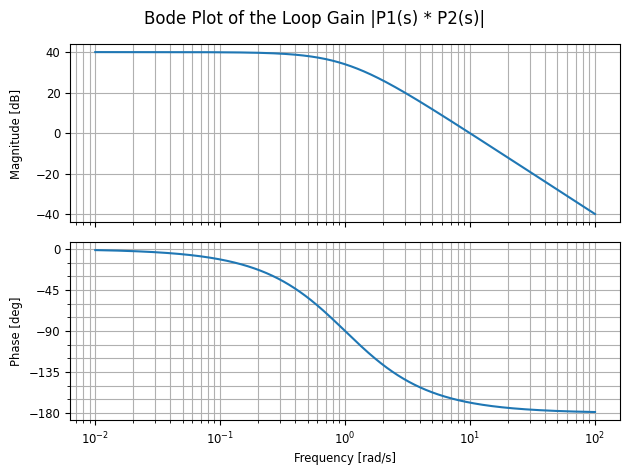

In [59]:
def plot_gain(P1, P2):
    omega = np.logspace(-2, 2, 1000)
    loop_gain = P1 * P2
    _, mag_dB, _ = ctrl.bode(loop_gain, omega, dB=True, plot=True)

    plt.suptitle("Bode Plot of the Loop Gain |P1(s) * P2(s)|")
    plt.show()

# Example: Creating transfer functions G(s) and H(s)

# P1(s) = 100 / (s + 1) (first order, high gain)
P1 = ctrl.TransferFunction([100], [1, 1])

# P2(s) = 0.1 / (s + 1) (first order)
P2 = ctrl.TransferFunction([1], [1, 1])

# Test Small Gain Theorem
stability = small_gain_theorem(P1, P2)

if stability:
    print("The system satisfies the Small Gain Theorem and is stable.")
else:
    print("The system does not satisfy the Small Gain Theorem and may be unstable.")

# Plot the loop gain
plot_gain(P1, P2)

# Exercise 2: Stability
In this exercise you will create a function called ``internal_stability_check(topbranch, bottombranch)`` that will check the internal stability of an interconnection.

Just as in exercise 1, you will use ``inf_pkg.SISO(num)`` to extract various transfer functions from the diagram.

__HINT:__ All the systems are SISO, so the inverse becomes rather simple.

<img src=./images/block_diagram_1.png alt="Image" width="600" height="200"> 

In [ ]:
# The top tf is defined as P0*P1
# The bottom tf is defined as P2

def internal_stability_check(toptf: ct.TransferFunction, bottomtf: ct.TransferFunction) -> bool:
    """
    Checks if the internal stability condition is satisfied for the given systems.

    Parameters:
    - ``toptf`` (ct.TransferFunction): The top transfer function
    - ``bottomtf`` (ct.TransferFunction): The bottom transfer function
    
    Returns:
    - bool: Whether the internal stability condition is satisfied
    """
    #TODO
    return False

In [ ]:
P0 = inf_pkg.SISO(0)
P1 = inf_pkg.SISO(1)
P2 = inf_pkg.SISO(2)

print(internal_stability_check(P0*P1, P2))

### Testing your function
You can test your function on the systems below:
$\\
P_0 = \frac{1}{s^2+2s+4} \\
P_1 = \frac{1}{s+1}  \\
P_2 = \frac{1}{s-1}  \\
P_3 = \frac{s-1}{s^2+4s+9} \\
P_4 = 5\frac{s+1}{s+1}  \\
P_5 = 11\frac{s+1}{s-1}  \\
P_6 = 2\frac{s^2-1}{s^2+4s+9} \\
$

In [ ]:
P3 = inf_pkg.SISO(3)
P4 = inf_pkg.SISO(4)
# P5 = ...

print(internal_stability_check(P3, P4))

### Solution
Access the solution ``sol_internal_stability_check`` by right-clicking and selecting "Go to Definition (F12)" or on [GitHub](https://github.com/idsc-frazzoli/cs2solutions/blob/f3185e17dd402ac5c504f83b502685a25a115ed3/src/cs2solutions/inf_pkg.py#L91).

In [ ]:
inf_pkg.sol_internal_stability_check(P0*P1, P2)

### Bonus Exercise

Try to find out experimentally whether ``small_gain_theorem`` or ``internal_stability_check`` is a more __rigorous__ test for feedback stability. You can use all aforementioned Python functions and transfer functions.

In [ ]:
# TODO

# Exercise 3: Stability Robustness
Below we check the robustness of a feedback loop with multiplicative uncertainty.

<img src=./images/block_diagram_2.png alt="Image" width="600" height="200">

In order to use the small-gain theorem, the system is transformed into the following form:
.
$\\
G(s) = -(I+P_2P_1)^{-1}P_2P_1W
\\$

<img src=./images/block_diagram_3.png alt="Image" width="600" height="200">


Apply the small gain theorem to check if the system is robust to the given perturbation and frequency weight. You can use all the functions defined earlier.

In [ ]:
Ptriangle = ct.TransferFunction([1], [1, 1])
W = ct.TransferFunction([1], [1, 1])
P1 = inf_pkg.SISO(1)
P2 = 0 #TODO

G = 0 #TODO

# TODO: Print the result

### Solution
Using the ``small_gain_theoerem`` function defined earlier.

In [ ]:
Ptriangle = ct.TransferFunction([1], [1, 1])
W = ct.TransferFunction([1], [1, 1])
P1 = inf_pkg.SISO(1)
P2 = inf_pkg.SISO(2)

G = -(1+P2*P1)**(-1)*P2*P1*W

inf_pkg.sol_small_gain_theorem([G, Ptriangle])